# stepped grating for interferometry (5-6Feb, 2017, Les)

## Step 1: Initialization

In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import os
from os import listdir
from os.path import isfile, join
import numpy  
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import string
from numpy.linalg import inv  #matrix calc
import math #log
import scipy
import scipy.ndimage
import scipy.signal #median filter for zero bad pixels
from astropy.io import fits #fits file read and writeTo
np.set_printoptions(suppress=True) #no scientific notations
import re #sort fits files
from IPython.display import clear_output #clear output

### Descriptions: make sure you put "raw/" file in the correct path

In [2]:
# user defined section
workdir = "/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical" #change your path here
rawPath = workdir
yourRawFilename = '3_Tomography/'
darkFilename = '4_Darkfield/'
whiteFilename = '1_FF_x5/'
angleIncrement = 360.0/199 #degree
par = angleIncrement
try:
    os.stat(os.path.join(workdir, 'FITS')) #create export file: FITS
except:
    os.mkdir(os.path.join(workdir, 'FITS'))    

## Step 2: functions

### Step 2.1: Reading files

In [3]:
def readFile(path, string):   #search string "white" and "raw"
    allFiles = [f for f in listdir(path) if isfile(join(path,f))]  
    for n in range(0, len(allFiles)):
        allFiles[n] = join(path,allFiles[n])
    allFiles.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)]) 
    #use "regular expression" to sort filenames
    listfile = [];
    for seq in range (0, len(allFiles)):
        if string in allFiles[seq]:
            listfile.append(allFiles[seq])
    print ('There are '+ str(len(listfile))+ ' '+ string + ' files')        
    return(listfile)

In [4]:
def funcReadAndorTIFFFile(filename, cropRows, cropColumns, binning, referenceDarkfield):
    binning = 2
    image = plt.imread(filename)
    data = np.array(image)
    data = data[cropRows[0]:cropRows[1], cropColumns[0]:cropColumns[1]]
    data = scipy.ndimage.zoom(data, 1.0/binning, order=1) #linear resampling
    data = data - referenceDarkfield
    return(data)

### Step 2.2: grouping

In [5]:
def funcGetSampleFilenamesForSpecificAngle(numSample, angle):
    numSteps = 12
    end = (angle/par+1)*12 - 1
    end = np.int(end)
    start = end - (numSteps - 1)
    sampleFileForThisAngle = []
    for i in range(start, end+1):
        sampleFileForThisAngle.append(sampleFiles[i])
    return(sampleFileForThisAngle)

In [6]:
def funcGetWhiteFilenamesForSpecificAngle(stack): #1~5 stacks of white images
    numSteps = 12
    end = stack*12-1
    end = np.int(end)
    start = end - (numSteps - 1)
    whiteFileforthisStack = []
    for i in range(start, end+1):
        whiteFileforthisStack.append(whiteFiles[i])
    return(whiteFileforthisStack)

### Step 2.3: Function for interferometry

In [7]:
def funcPrepareBvectorArbitrarySteps(gratingPeriodMicrons, listGratingStepsMicrons):
    numberGratingSteps = len(listGratingStepsMicrons)
    b1 = np.ones((numberGratingSteps))
    b2 = np.zeros((numberGratingSteps))
    b3 = np.zeros((numberGratingSteps))
    for i in range(numberGratingSteps):
        b2[i] = np.sin(2*np.pi*listGratingStepsMicrons[i] / gratingPeriodMicrons)
        b3[i] = np.cos(2*np.pi*listGratingStepsMicrons[i] / gratingPeriodMicrons)        
    return(np.column_stack((b1,b2,b3)))
#funcPrepareBvectorArbitrarySteps(gratingPeriodMicrons, listGratingStepsMicrons)

In [8]:
def funcPrepareAllVectors(gratingPeriodMicrons, listGratingStepsMicrons, rows, columns):
    bVector = funcPrepareBvectorArbitrarySteps(gratingPeriodMicrons, listGratingStepsMicrons)
    aVector = cVector = np.zeros((3, rows * columns))
    aMatrix = np.zeros((rows, columns, 3))
    amplitude = phi = np.zeros((rows, columns))
    gMatrix = np.dot(inv(np.dot(np.transpose(bVector), bVector)), np.transpose(bVector))
    return(gMatrix, bVector, aVector, aMatrix, amplitude, phi)

In [9]:
def funcReadOneInterferogram(listFilenamesOneInterferogram, rows, columns, listGratingStepsMicrons):
    numberGratingSteps = len(listGratingStepsMicrons)
    allData = np.zeros((rows, columns, numberGratingSteps))
    for index in range(numberGratingSteps):
        filename = listFilenamesOneInterferogram[index]
        intensity = funcReadAndorTIFFFile(filename, cropRows, cropColumns, binning, referenceDarkfield)
        allData[:,:,index] = intensity
    return(allData)

In [10]:
def funcCalculateOffsetAmplitudePhi(data):
    numberGratingSteps = len(listGratingStepsMicrons)
    cVector = np.transpose(np.reshape(data, (rows*columns, numberGratingSteps)))
    aVector = np.dot(gMatrix, cVector)
    aMatrix = np.reshape(np.transpose(aVector), (rows, columns, 3)) 
    offset = aMatrix[:,:,0]
    amplitude = np.sqrt(aMatrix[:,:,1]**2 + aMatrix[:,:,2]**2)
    phi = np.arctan2(aMatrix[:,:,2], aMatrix[:,:,1])
    amplitudePercent = 100 * amplitude / offset
    return(offset, amplitude, phi)

In [11]:
def funcCorrectForZeroValuePixels(dataOriginal):
    coordinatesZeroIntensityPixels = np.transpose(np.where(dataOriginal == 0))
    dataCorrected = dataOriginal
    if (len(coordinatesZeroIntensityPixels > 0)):
        dataMedianFilter = scipy.signal.medfilt(dataOriginal, 1) # medfilt Ordering = 1
    for index in range(len(coordinatesZeroIntensityPixels)):
        [r, c] = coordinatesZeroIntensityPixels[index]
        dataCorrected[r, c] = dataMedianFilter[r, c]
    return(dataCorrected)

In [12]:
def funcCorrectLargeDPCValue(data):
    dataCorrected = data
    coordinatesLargeDPC = np.transpose(np.where(data > np.pi))
    if (len(coordinatesLargeDPC) > 0):
        for index in range(len(coordinatesLargeDPC)):
            [r, c] = coordinatesLargeDPC[index]
            dataCorrected[r,c] = data[r, c] - 2*np.pi
    coordinatesLargeDPC = np.transpose(np.where(differentialPhase < -np.pi))
    if (len(coordinatesLargeDPC) > 0):
        for index in range(len(coordinatesLargeDPC)):
            [r, c] = coordinatesLargeDPC[index]
            dataCorrected[r, c] = data[r, c] + 2*np.pi
    return(dataCorrected)

## Step 3: Paths, filenames and grouping

In [13]:
rawData = os.path.join(rawPath, yourRawFilename) 
fitsFile = os.path.join(workdir, 'FITS/')
print ('Your working directory is "', workdir, '"')
print ()

Your working directory is " /run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical "



In [14]:
whiteFiles = readFile(whiteFilename, 'FF') #flat-field 
sampleFiles = readFile(rawData, 'Tomo')
darkFiles = readFile(darkFilename, 'Dark')
print()
numWhite = len(whiteFiles)
numSample = len(sampleFiles)
numDark = len(darkFiles)
print (np.transpose(whiteFiles[0:4]))
print()
print (np.transpose(sampleFiles[0:4]))

There are 60 FF files
There are 2400 Tomo files
There are 15 Dark files

['1_FF_x5/FF_x5_0001.tif' '1_FF_x5/FF_x5_0002.tif' '1_FF_x5/FF_x5_0003.tif'
 '1_FF_x5/FF_x5_0004.tif']

[ '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0001.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0002.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0003.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0004.tif']


### Cropping

Before cropping:


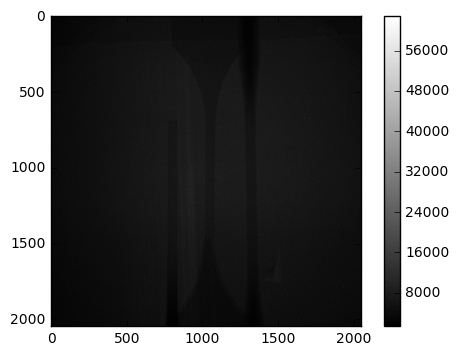

After cropping and binning: (874, 650)


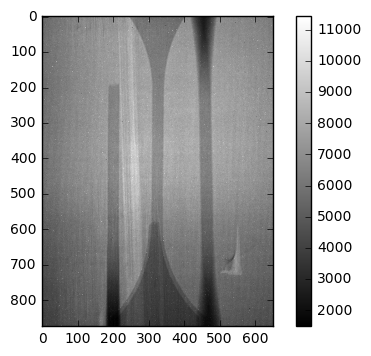

In [15]:
oneImg = np.array(plt.imread(sampleFiles[0]))
[NY, NX] = oneImg.shape
[rows, columns] = oneImg.shape
print ("Before cropping:")
plt.imshow(oneImg, cmap = "gray")
plt.colorbar()
plt.show()
cropRows = [300, NY]
cropColumns = [400, 1700]
binning = 2
oneImageCrop = oneImg[cropRows[0]: cropRows[1], cropColumns[0]: cropColumns[1]]
oneImageCrop = scipy.ndimage.zoom(oneImageCrop, 1.0/binning, order=1) #linear resampling
print ("After cropping and binning:", oneImageCrop.shape)
plt.imshow(oneImageCrop, cmap = "gray")
plt.colorbar()
plt.show()

### based on cropping and binning, calculate dark-field

In [16]:
[NY, NX]=[cropRows[1]-cropRows[0]+1, cropColumns[1]-cropColumns[0]+1]
print (darkFiles, "\n\n", NY, NX, "\n\n", numDark)
binning = 2
referenceDarkfield = np.zeros((numDark, NY/2, NX/2))
for i in range (numDark):
    image = np.array(plt.imread(darkFiles[i]))
    image = image[cropRows[0]:cropRows[1], cropColumns[0]:cropColumns[1]]
    image = scipy.ndimage.zoom(image, 1.0/binning, order=1)
    referenceDarkfield[i,:,:] = image
print (referenceDarkfield.shape)
referenceDarkfield = np.median(referenceDarkfield, axis = 0)
print ()
print (referenceDarkfield.shape)
print (np.min(referenceDarkfield), np.mean(referenceDarkfield), np.max(referenceDarkfield))
[rows, columns] = referenceDarkfield.shape
rows, columns

['4_Darkfield/Darkfield_0001.tif', '4_Darkfield/Darkfield_0002.tif', '4_Darkfield/Darkfield_0003.tif', '4_Darkfield/Darkfield_0004.tif', '4_Darkfield/Darkfield_0005.tif', '4_Darkfield/Darkfield_0006.tif', '4_Darkfield/Darkfield_0007.tif', '4_Darkfield/Darkfield_0008.tif', '4_Darkfield/Darkfield_0009.tif', '4_Darkfield/Darkfield_0010.tif', '4_Darkfield/Darkfield_0011.tif', '4_Darkfield/Darkfield_0012.tif', '4_Darkfield/Darkfield_0013.tif', '4_Darkfield/Darkfield_0014.tif', '4_Darkfield/Darkfield_0015.tif'] 

 1749 1301 

 15
(15, 874, 650)

(874, 650)
796.0 799.894604823 1100.0


(874, 650)

## Step 4: Look at one angle here

In [17]:
#user defined
angle = 360.0/199*0 #must be divided by 360/199
print ('the one angle you want to look at is: ', angle, '\n')
print('If not, please change angle =', angle, 'above. Thanks!')

the one angle you want to look at is:  0.0 

If not, please change angle = 0.0 above. Thanks!


In [18]:
numSteps = 12
finalAngle = 360 #dergee
print("number of steps is:", numSteps, "\nthe sample rotates from 0 degree to", finalAngle, "degree" \
      , "angle increment is 360/199 =", angleIncrement, "degree")
numberOfAngles = numSample / numSteps
print("The number of angles is:", numberOfAngles)

number of steps is: 12 
the sample rotates from 0 degree to 360 degree angle increment is 360/199 = 1.80904522613 degree
The number of angles is: 200


In [19]:
listFilenamesSampleOneInterferogram = funcGetSampleFilenamesForSpecificAngle(numSample, angle)
print (np.transpose(listFilenamesSampleOneInterferogram))
print('\nNumber of angle', angle, 'sample files:', len(listFilenamesSampleOneInterferogram))

[ '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0001.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0002.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0003.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0004.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0005.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0006.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0007.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0008.tif'
 '/run/media/tomouser/MercurySSD/HZB_Mar2017/Expt2_AM_TENS_Tomo_vertical/3_Tomography/Tomography_0009.tif'
 '/run/media/tomouser/MercurySSD/HZB

In [20]:
print ("cropping range:\n", cropRows, "\n", cropColumns)
gratingPeriodMicrons = 790 #pixel size = ? microns
listGratingStepsMicrons = np.zeros((12))
numberGratingSteps = numSteps
for i in range(0, 12):
    listGratingStepsMicrons[i] = 1200/(numberGratingSteps-1)*i
print (listGratingStepsMicrons)

cropping range:
 [300, 2048] 
 [400, 1700]
[    0.   109.   218.   327.   436.   545.   654.   763.   872.   981.
  1090.  1199.]


In [21]:
print ('sample name:                      ', sampleFiles[0].split("/")[6])
print ('grating period (in microns):      ', gratingPeriodMicrons)
print ('grating steps (in microns):       ', listGratingStepsMicrons)
print ('# of grating steps:               ', len(listGratingStepsMicrons))
print ('# of dark images:                 ', len(darkFiles))
print ('# of reference images (white):    ', len(whiteFiles))
print ('# of sample images (raw):         ', len(sampleFiles))

sample name:                       Expt2_AM_TENS_Tomo_vertical
grating period (in microns):       790
grating steps (in microns):        [    0.   109.   218.   327.   436.   545.   654.   763.   872.   981.
  1090.  1199.]
# of grating steps:                12
# of dark images:                  15
# of reference images (white):     60
# of sample images (raw):          2400


In [22]:
listSampleAngles = np.zeros((np.int(finalAngle/par+1)))
for i in range(len(listSampleAngles)):
    listSampleAngles[i] = i*par
print ('There are', len(listSampleAngles), 'angles:', '\n\n', listSampleAngles)
numberOfAngles = len(listSampleAngles)
#clear_output()
360/199.0

There are 200 angles: 

 [   0.            1.80904523    3.61809045    5.42713568    7.2361809
    9.04522613   10.85427136   12.66331658   14.47236181   16.28140704
   18.09045226   19.89949749   21.70854271   23.51758794   25.32663317
   27.13567839   28.94472362   30.75376884   32.56281407   34.3718593
   36.18090452   37.98994975   39.79899497   41.6080402    43.41708543
   45.22613065   47.03517588   48.84422111   50.65326633   52.46231156
   54.27135678   56.08040201   57.88944724   59.69849246   61.50753769
   63.31658291   65.12562814   66.93467337   68.74371859   70.55276382
   72.36180905   74.17085427   75.9798995    77.78894472   79.59798995
   81.40703518   83.2160804    85.02512563   86.83417085   88.64321608
   90.45226131   92.26130653   94.07035176   95.87939698   97.68844221
   99.49748744  101.30653266  103.11557789  104.92462312  106.73366834
  108.54271357  110.35175879  112.16080402  113.96984925  115.77889447
  117.5879397   119.39698492  121.20603015  123.015075

1.8090452261306533

### initialize vectors used for the calculation

In [23]:
[gMatrix, bVector, aVector, aMatrix, amplitude, phi] = funcPrepareAllVectors(gratingPeriodMicrons, listGratingStepsMicrons, rows, columns)
print (gMatrix.shape)
print (bVector.shape)
print (aVector.shape)
print (aMatrix.shape) 
print (amplitude.shape) 
print (phi.shape)

(3, 12)
(12, 3)
(3, 568100)
(874, 650, 3)
(874, 650)
(874, 650)


### calculate white/reference -- offset, phi and amplitude

In [24]:
numStacksForWhite = numWhite / numSteps
print ("There are", numStacksForWhite, "stacks flat-field/white samples\n")
stack = 1  #stack = 1,2,3,4,5
print ("stack#:", stack, "\n")
listFilenamesReferenceOneInterferogram = funcGetWhiteFilenamesForSpecificAngle(stack)
print (np.transpose(listFilenamesReferenceOneInterferogram))

There are 5 stacks flat-field/white samples

stack#: 1 

['1_FF_x5/FF_x5_0001.tif' '1_FF_x5/FF_x5_0002.tif' '1_FF_x5/FF_x5_0003.tif'
 '1_FF_x5/FF_x5_0004.tif' '1_FF_x5/FF_x5_0005.tif' '1_FF_x5/FF_x5_0006.tif'
 '1_FF_x5/FF_x5_0007.tif' '1_FF_x5/FF_x5_0008.tif' '1_FF_x5/FF_x5_0009.tif'
 '1_FF_x5/FF_x5_0010.tif' '1_FF_x5/FF_x5_0011.tif' '1_FF_x5/FF_x5_0012.tif']


In [25]:
interferogramReference = funcReadOneInterferogram(listFilenamesReferenceOneInterferogram, rows, columns, 
                                                  listGratingStepsMicrons)
print (interferogramReference.shape)

(874, 650, 12)


In [26]:
np.seterr(divide='ignore', invalid='ignore') #code have some "divided by zero" or "Nan" appears
[referenceOffset, referenceAmplitude, referencePhi] = \
        funcCalculateOffsetAmplitudePhi(interferogramReference)
print ('reference Offset:')
print (referenceOffset.shape, np.min(referenceOffset), 
      np.mean(referenceOffset.flatten()), np.max(referenceOffset))
print ('reference Amplitude')
print (referenceAmplitude.shape, np.min(referenceAmplitude), 
      np.mean(referenceAmplitude.flatten()), np.max(referenceAmplitude))
print ('reference Phi')
print (referencePhi.shape, np.min(referencePhi), 
      np.mean(referencePhi.flatten()), np.max(referencePhi))

reference Offset:
(874, 650) 2411.21974549 5929.5411955 9812.17423757
reference Amplitude
(874, 650) 5.54856258442 388.696732097 1873.72972789
reference Phi
(874, 650) -3.14140211673 -0.601226008986 3.14030046491


reference offset:


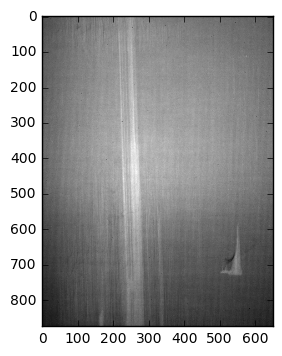

reference phi


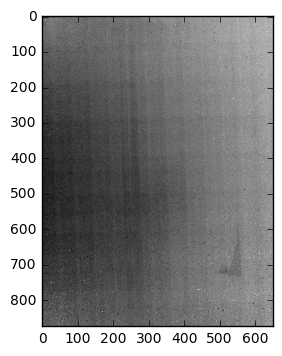

reference amplitude


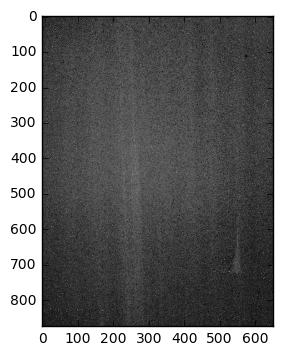

In [27]:
print ("reference offset:")
plt.imshow(referenceOffset, cmap = "gray")
plt.show()
print ("reference phi")
plt.imshow(referencePhi, cmap = "gray")
plt.show()
print ("reference amplitude")
plt.imshow(referenceAmplitude, cmap = "Greys_r")
plt.show()

### median processing for flat-field/white/reference 12 steppings

In [28]:
refOffset = np.zeros((numStacksForWhite, rows, columns))
refAmplitude = np.zeros((numStacksForWhite, rows, columns))
refPhi = np.zeros((numStacksForWhite, rows, columns))
for i in range(numStacksForWhite):
    #print (i)
    listFilenamesReferenceOneInterferogram = funcGetWhiteFilenamesForSpecificAngle(i+1)
    #print (np.transpose(listFilenamesReferenceOneInterferogram))
    interferogramReference = funcReadOneInterferogram(listFilenamesReferenceOneInterferogram, rows, columns, \
                                                      listGratingStepsMicrons)
    [referenceOffset, referenceAmplitude, referencePhi] = \
    funcCalculateOffsetAmplitudePhi(interferogramReference)
    refOffset[i,:,:] = referenceOffset
    refAmplitude[i,:,:] = referenceAmplitude
    refPhi[i,:,:] = referencePhi
    """
    plt.imshow(referenceOffset, cmap = "Greys_r")
    plt.show()
    plt.imshow(refOffset[i,:,:], cmap = "Greys_r")
    plt.show()
    """


In [29]:
index=0
print ("reference offset:")
plt.imshow(refOffset[index,:,:], cmap = "gray")
plt.show()
print ("reference phi")
plt.imshow(refPhi[index,:,:], cmap = "gray")
plt.show()
print ("reference amplitude")
plt.imshow(refAmplitude[index,:,:], cmap = "Greys_r")
plt.show()
clear_output()

In [30]:
print (np.median(refOffset, axis=0).shape)
referenceOffset = np.median(refOffset, axis=0)
referencePhi = np.median(refPhi, axis=0)
referenceAmplitude = np.median(refAmplitude, axis=0)

(874, 650)


reference offset:


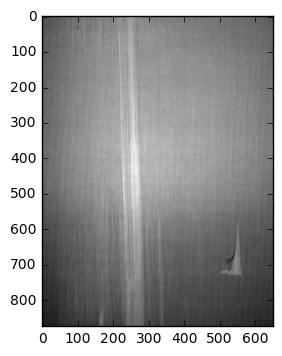

reference phi


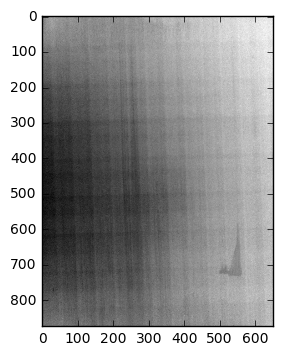

reference amplitude


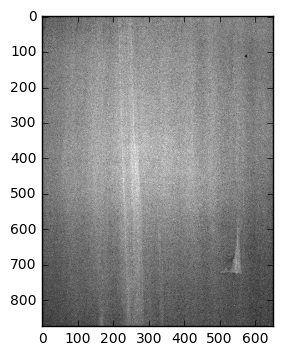

In [31]:
print ("reference offset:")
plt.imshow(referenceOffset, cmap = "gray")
plt.show()
print ("reference phi")
plt.imshow(referencePhi, cmap = "gray")
plt.show()
print ("reference amplitude")
plt.imshow(referenceAmplitude, cmap = "gray")
plt.show()

### calculate samples -- offset, phi and amplitude

In [32]:
interferogramSample = funcReadOneInterferogram(listFilenamesSampleOneInterferogram, rows, columns, listGratingStepsMicrons)
print (interferogramSample.shape)

(874, 650, 12)


In [33]:
[sampleOffset, sampleAmplitude, samplePhi] = funcCalculateOffsetAmplitudePhi(interferogramSample)
print ('sample Offset:')
print (sampleOffset.shape, np.min(sampleOffset), 
      np.mean(sampleOffset.flatten()), np.max(sampleOffset))
print ('sample Amplitude')
print (sampleAmplitude.shape, np.min(sampleAmplitude), 
      np.mean(sampleAmplitude.flatten()), np.max(sampleAmplitude))
print ('sample Phi')
print (samplePhi.shape, np.min(samplePhi), 
      np.mean(samplePhi.flatten()), np.max(samplePhi))

sample Offset:
(874, 650) 659.036825714 5664.29194623 9837.64714283
sample Amplitude
(874, 650) 0.257081621686 319.459717561 1581.93333458
sample Phi
(874, 650) -3.14152407334 -0.0852824968553 3.14139391944


In [34]:
print (np.transpose(np.where(referenceOffset == 0)))
referenceOffset = funcCorrectForZeroValuePixels(referenceOffset)
print (np.transpose(np.where(referenceOffset == 0)))

print (np.transpose(np.where(sampleOffset == 0)))
sampleOffset = funcCorrectForZeroValuePixels(sampleOffset)
print (np.transpose(np.where(sampleOffset == 0)))

print (np.transpose(np.where(referenceAmplitude == 0)))
referenceAmplitude = funcCorrectForZeroValuePixels(referenceAmplitude)
print (np.transpose(np.where(referenceAmplitude == 0)))

[]
[]
[]
[]
[]
[]


### plot offset, amplitude, and phi for ref and sample

In [35]:
testPointOne = (np.round(columns/2), np.round(rows/2))
print (testPointOne)
climOffset = [np.min(referenceOffset), np.max(referenceOffset)]
climAmplitude = [np.min(referenceAmplitude), np.max(referenceAmplitude)]
climPhi = [np.min(referencePhi), np.max(referencePhi)]

(325, 437)


In [36]:
plt.imshow(referenceOffset, cmap='gray')
#plt.colorbar()
plt.show()
plt.imshow(referenceAmplitude, cmap='gray')
plt.show()
plt.imshow(referencePhi, cmap='gray')
plt.show()
clear_output()

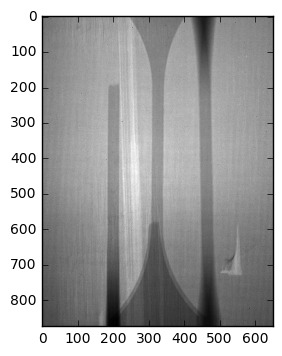

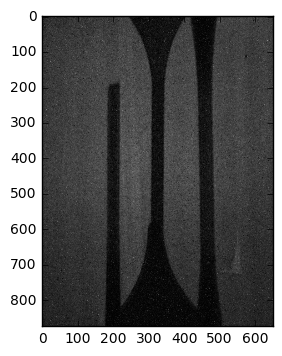

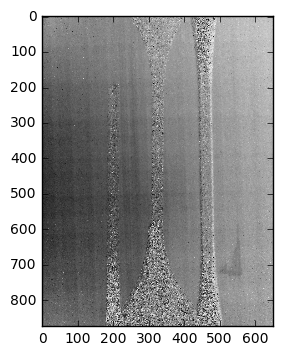

In [37]:
plt.imshow(sampleOffset, cmap='gray')
plt.show()
plt.imshow(sampleAmplitude, cmap='gray')
plt.show()
plt.imshow(samplePhi, cmap='gray')
plt.show()
#clear_output()

### calculate abs, dpc, and dark-field

In [38]:
absorption = -np.log(sampleOffset / referenceOffset)
print (np.min(absorption), np.mean(absorption.flatten()), np.max(absorption))

-0.182136347891 0.0706571737798 1.82371473711


In [39]:
differentialPhase = samplePhi - referencePhi
print (np.min(differentialPhase), np.mean(differentialPhase.flatten()), np.max(differentialPhase))

-4.48240801461 0.327661686837 5.18297925046


In [40]:
differentialPhase = funcCorrectLargeDPCValue(differentialPhase)
print (np.min(differentialPhase), np.mean(differentialPhase.flatten()), np.max(differentialPhase))

-3.14146603835 0.304734309365 3.14141691147


In [41]:
darkfield = (sampleAmplitude / referenceAmplitude) / (sampleOffset / referenceOffset)
print (np.min(darkfield), np.mean(darkfield), np.max(darkfield))

0.00122789978403 0.83794712919 6.76863713713


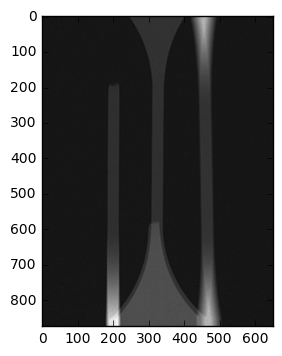

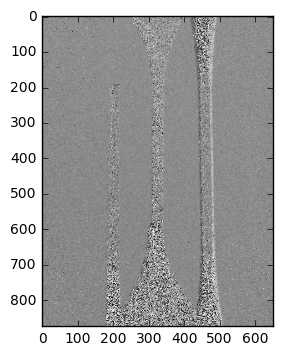

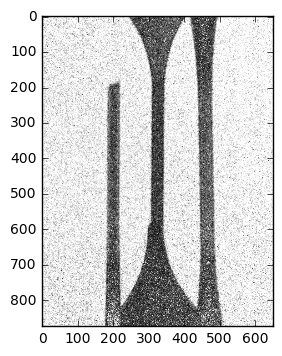

In [42]:
plt.imshow(absorption, cmap = 'gray')
plt.show()
plt.imshow(differentialPhase, cmap = 'gray', vmax = np.pi, vmin = -np.pi)
plt.show()
plt.imshow(darkfield, cmap = 'gray', vmax = 1, vmin = 0)
plt.show()
#clear_output()

## Step 5: for all angles, process ref and sample

In [43]:
[gMatrix, bVector, aVector, aMatrix, amplitude, phi] = funcPrepareAllVectors(gratingPeriodMicrons, listGratingStepsMicrons, rows, columns)
print (gMatrix.shape, bVector.shape, aVector.shape, aMatrix.shape, amplitude.shape, phi.shape)

(3, 12) (12, 3) (3, 568100) (874, 650, 3) (874, 650) (874, 650)


In [44]:
oldlistFilenamesReferenceOneInterferogram = " "
sampleName = sampleFiles[0].split("/")[6]
print('sample name:', sampleName)
numberOfAngles

sample name: Expt2_AM_TENS_Tomo_vertical


200

reference offset:


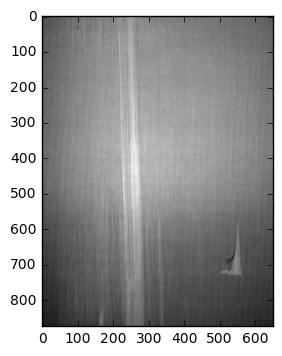

reference phi


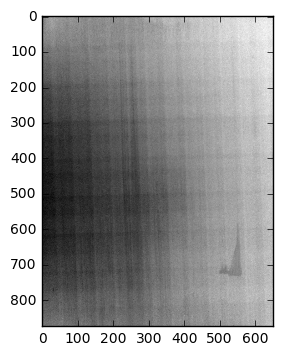

reference amplitude


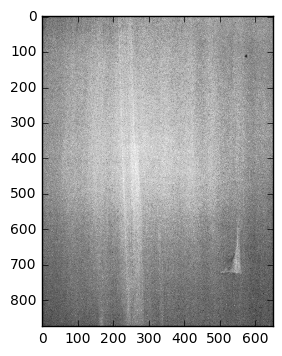

In [45]:
print ("reference offset:")
plt.imshow(referenceOffset, cmap = "gray")
plt.show()
print ("reference phi")
plt.imshow(referencePhi, cmap = "gray")
plt.show()
print ("reference amplitude")
plt.imshow(referenceAmplitude, cmap = "Greys_r")
plt.show()

In [46]:
numberOfAngles, rows, columns

(200, 874, 650)

In [439]:
for indexListAngle in range(numberOfAngles):
    angle = listSampleAngles[indexListAngle]
    
    referenceOffset = referenceOffset
    referencePhi = referencePhi
    referenceAmplitude = referenceAmplitude
    
    listFilenamesSampleOneInterferogram = funcGetSampleFilenamesForSpecificAngle(numSample, angle)
    print (indexListAngle, '# of sample images =', len(listFilenamesSampleOneInterferogram))
    interferogramSample = funcReadOneInterferogram(listFilenamesSampleOneInterferogram, rows,
                                                  columns, listGratingStepsMicrons)
    print (indexListAngle, angle)
    [sampleOffset, sampleAmplitude, samplePhi] = funcCalculateOffsetAmplitudePhi(interferogramSample)
    absorption = -np.log(sampleOffset / referenceOffset)
    differentialPhase = samplePhi - referencePhi
    differentialPhase = funcCorrectLargeDPCValue(differentialPhase)
    darkfield = (sampleAmplitude / sampleAmplitude) / (sampleOffset / referenceOffset)
    #darkfield = 1 - darkfield
    #fits file writeTo http://docs.astropy.org/en/stable/io/fits/
    
    #write abs FITS files
    absFilename = os.path.join(fitsFile, sampleName + '_abs_' + np.str(angle/par+1) + '.fits')
    try: #remove file if exits
        os.remove(absFilename)
    except OSError:
        pass
    absFits = fits.HDUList([fits.PrimaryHDU(absorption)])
    absFits.writeto(absFilename)
    absFits.close()
    
    #write dpc FITS files
    dpcFilename = os.path.join(fitsFile, sampleName + '_dpc_' + np.str(angle/par+1) + '.fits')
    try: #remove file if exits
        os.remove(dpcFilename)
    except OSError:
        pass
    absFits = fits.HDUList([fits.PrimaryHDU(differentialPhase)])
    absFits.writeto(dpcFilename)
    absFits.close()
    
    #write darkfield FITS files
    dfFilename = os.path.join(fitsFile, sampleName + '_darkfield_' + np.str(angle/par+1) + '.fits')
    try: #remove file if exits
        os.remove(dfFilename)
    except OSError:
        pass
    absFits = fits.HDUList([fits.PrimaryHDU(darkfield)])
    absFits.writeto(dfFilename)
    absFits.close()
    clear_output()
